# 3.2 GridMET 

In this chapter, we delve into the automation of meteorological `GridMET` data acquisition and preprocessing. By systematically downloading, processing, and integrating this data, we aim to create a robust foundation for environmental analysis.

GridMET is a high-resolution dataset that provides daily surface meteorological data for the contiguous United States

## Utility Functions for GridMET Climatology Data Downloader

## 1. Setup and Variable Mapping

The following code snippet sets up the environment by importing necessary libraries, defining a workspace, and mapping variables.

- `gridmet_var_mapping`: A dictionary that associates short-form variable names with their full descriptive names.

- The `colors` list represents a gradient of colors associated with specific ranges of values

In [1]:
## Utility Functions

import os
import numpy as np
import pandas as pd
import netCDF4 as nc
import urllib.request
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt

work_dir = "../data/gridmet_test_run"

gridmet_var_mapping = {
  "etr": "potential_evapotranspiration",
  "pr":"precipitation_amount",
  "rmax":"relative_humidity",
  "rmin":"relative_humidity",
  "tmmn":"air_temperature",
  "tmmx":"air_temperature",
  "vpd":"mean_vapor_pressure_deficit",
  "vs":"wind_speed",
}

colors = [
    (0.8627, 0.8627, 0.8627),  # #DCDCDC - 0 - 1
    (0.8627, 1.0000, 1.0000),  # #DCFFFF - 1 - 2
    (0.6000, 1.0000, 1.0000),  # #99FFFF - 2 - 4
    (0.5569, 0.8235, 1.0000),  # #8ED2FF - 4 - 6
    (0.4509, 0.6196, 0.8745),  # #739EDF - 6 - 8
    (0.4157, 0.4706, 1.0000),  # #6A78FF - 8 - 10
    (0.4235, 0.2784, 1.0000),  # #6C47FF - 10 - 12
    (0.5529, 0.0980, 1.0000),  # #8D19FF - 12 - 14
    (0.7333, 0.0000, 0.9176),  # #BB00EA - 14 - 16
    (0.8392, 0.0000, 0.7490),  # #D600BF - 16 - 18
    (0.7569, 0.0039, 0.4549),  # #C10074 - 18 - 20
    (0.6784, 0.0000, 0.1961),  # #AD0032 - 20 - 30
    (0.5020, 0.0000, 0.0000)   # #800000 - > 30
]


## 2. Map Values to Colors

Here we generate a color mapping for a given column of data based on specified or automatically calculated value ranges. It returns the color mapping and the value ranges used.

- `df_col` (required): The data column from a DataFrame to map to colors.
- `value_ranges` (optional): A list of value ranges to determine the mapping of data values to colors. If not provided, the function calculates the ranges automatically.
- `map_value_to_color` takes a value and maps it to a color based on the `new_value_ranges`.
- It iterates through the ranges, assigning a color to the value based on which range it falls into.
- If the value is greater than all the defined ranges, the last color in the list is used.

we get the `color_mapping` (list of colors corresponding to each value in the data column) and `new_value_ranges` (the calculated or provided value ranges).

In [3]:
def create_color_maps_with_value_range(df_col, value_ranges=None):
  if value_ranges == None:
    max_value = df_col.max()
    min_value = df_col.min()
    if min_value < 0:
      min_value = 0
    step_size = (max_value - min_value) / 12

    # Create 10 periods
    new_value_ranges = [min_value + i * step_size for i in range(12)]
  # Define your custom function to map data values to colors
  def map_value_to_color(value):
    # Iterate through the value ranges to find the appropriate color index
    for i, range_max in enumerate(new_value_ranges):
      if value <= range_max:
        return colors[i]

      # If the value is greater than the largest range, return the last color
      return colors[-1]

    # Map predicted_swe values to colors using the custom function
  color_mapping = [map_value_to_color(value) for value in df_col.values]
  return color_mapping, new_value_ranges

## 3. Retrive the Current Year

The following code snippet retrives the current year from the system's date and time.

In [2]:
def get_current_year():
    """
    Get the current year.

    Returns:
        int: The current year.
    """
    now = datetime.now()
    current_year = now.year
    return current_year

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


## 4. Removes Specific Files in a Folder

We remove all files within the specified folder.

- `folder_path`: A string representing the directory where files are to be removed.
- `current_year`: An integer representing the current year, used to filter which files should be deleted.
- `files`: A list containing the names of all items (files and directories) within the specified folder.
- `file_path`: A string representing the full path to each file in the folder, constructed by joining folder_path and the file name.

- The function then loops through each item in the `files` list. For each item:
    - `file_path = os.path.join(folder_path, file)` constructs the full path to the file by combining the folder path and the file name.
    - `if os.path.isfile(file_path) and str(current_year) in file_path and file_path.endswith(".nc"):` checks if the item is a file (not a directory), if the file name contains the current year as a substring, and if the file has a `.nc` extension (indicating a NetCDF file).
  - If all these conditions are met, the file is deleted using `os.remove(file_path)`, and a message is printed to confirm the deletion.

In [4]:
def remove_files_in_folder(folder_path, current_year):
    """
    Remove all files in a specified folder.

    Parameters:
        folder_path (str): Path to the folder to remove files from.
    """
    # Get a list of files in the folder
    files = os.listdir(folder_path)

    # Loop through the files and remove them
    for file in files:
        file_path = os.path.join(folder_path, file)
        if os.path.isfile(file_path) and str(current_year) in file_path and file_path.endswith(".nc"):
            os.remove(file_path)
            print(f"Deleted file: {file_path}")

## 5. Download File from a URL

Here we download a file from a given URL and saves it to a specified location.

- `url`: A string representing the URL from which the file is to be downloaded.
    - `target_file_path`: A string representing the path where the downloaded file should be saved.

- `with urllib.request.urlopen(url) as response:` opens a connection to the provided URL.
   - `file_content = response.read()` reads the contents of the file from the URL.

In [5]:
def download_file(url, target_file_path, variable):
    """
    Download a file from a URL and save it to a specified location.

    Parameters:
        url (str): URL of the file to download.
        target_file_path (str): Path where the downloaded file should be saved.
        variable (str): Name of the meteorological variable being downloaded.
    """
    try:
        with urllib.request.urlopen(url) as response:
            print(f"Downloading {url}")
            file_content = response.read()
        save_path = target_file_path
        with open(save_path, 'wb') as file:
            file.write(file_content)
        print(f"File downloaded successfully and saved as: {os.path.basename(save_path)}")
    except Exception as e:
        print(f"An error occurred while downloading the file: {str(e)}")

## 6. Downloads Specific Meteorological Variables

Here we download specific meteorological variables from the GridMET climatology dataset for a list of years provided as input.

- `year_list`: A list of years for which the meteorological data is to be downloaded.
- `base_metadata_url` is a string that stores the base URL from where the meteorological data files will be downloaded.
- `variables_list` is a list containing the short names of the meteorological variables to be downloaded, such as `tmmn` (minimum temperature), `tmmx` (maximum temperature), `pr` (precipitation), `vpd` (vapor pressure deficit), `etr` (evapotranspiration), `rmax` (maximum relative humidity), `rmin` (minimum relative humidity), `vs` (wind speed).

- The function loops through each variable in `variables_list`.
- For each variable, it further loops through each year in `year_list`.

In [6]:
def download_gridmet_of_specific_variables(year_list):
    """
    Download specific meteorological variables from the GridMET climatology dataset.
    """
    # Make a directory to store the downloaded files

    base_metadata_url = "http://www.northwestknowledge.net/metdata/data/"
    variables_list = ['tmmn', 'tmmx', 'pr', 'vpd', 'etr', 'rmax', 'rmin', 'vs']

    for var in variables_list[:3]:
        for y in year_list:
            download_link = base_metadata_url + var + '_' + '%s' % y + '.nc'
            target_file_path = os.path.join(gridmet_folder_name, var + '_' + '%s' % y + '.nc')
            if not os.path.exists(target_file_path):
                download_file(download_link, target_file_path, var)
            else:
                print(f"File {os.path.basename(target_file_path)} exists")

## 7. Extract File Name from File Path

Here we extracts the file name from a given file path.
- `file_path`: A string representing the full path to a file.
- `file_name = os.path.basename(file_path)` uses the `os.path.basename()` function to extract the file name from the complete file path. The `basename()` function returns the last component of the path, which is the file name.

In [7]:
def get_file_name_from_path(file_path):
    # Get the file name from the file path
    file_name = os.path.basename(file_path)
    return file_name

## 8. Extract Variable Name from File Name

The code snippet extracts the variable name from a given file name, assuming the file name follows a specific format.

- `file_name`: A string representing the name of the file from which the variable name will be extracted.
- `var_name = str(file_name.split('_')[0])` splits the file name at the underscore and takes the first part (index `0`), which is expected to be the variable name. The `str()` function ensures that `var_name` is treated as a string.

In [8]:
def get_var_from_file_name(file_name):
    # Assuming the file name format is "tmmm_year.csv"
    var_name = str(file_name.split('_')[0])
    return var_name

## 9. Extracts Coordinates from a CSV File

Here we extracts geographical coordinates (longitude and latitude) from a CSV file and returns them as a list of tuples.

- `coordinates`: A list initialized as empty and used to store tuples of longitude and latitude values extracted from the CSV file.
- `df`: A DataFrame created by loading the CSV file using `pandas`. It contains the data from the CSV, including the `Latitude` and `Longitude` columns.
- `lon`: Represents the longitude extracted from the current row of the DataFrame.
- `lat`: Represents the latitude extracted from the current row of the DataFrame.
- Here we iterate over each row in the DataFrame using a `for` loop: `for index, row in df.iterrows():`.
- For each row, the function extracts the `Latitude` and `Longitude` values, converting them to floating-point numbers: `lon, lat = float(row["Latitude"]), float(row["Longitude"])`.
- These coordinates are appended to the `coordinates` list as a tuple: `coordinates.append((lon, lat))`.

In [9]:
def get_coordinates_of_template_tif():
  	# Load the CSV file and extract coordinates
    coordinates = []
    df = pd.read_csv(dem_csv)
    for index, row in df.iterrows():
        # Process each row here
        lon, lat = float(row["Latitude"]), float(row["Longitude"])
        coordinates.append((lon, lat))
    return coordinates

## 10. Find the Nearest Index in an Array

- `array`: A `numpy` array of numerical values from which the closest element to `value` is to be found.
- `value`: A numerical value for which the closest corresponding element in `array` is sought.

The code snippet returns the `index` of the element in the array that is closest to the given `value`.

In [10]:
def find_nearest_index(array, value):
    # Find the index of the element in the array that is closest to the given value
    return (abs(array - value)).argmin()

## 11. Calculate specific Operation Day

Here we calculate the date exactly three days before the current date and returns it as a formatted string.

- `current_date`: A `datetime` object representing the current date and time.
- `three_days_ago`: A `datetime` object representing the date three days before the current date.
- `three_days_ago_string`: A string representing the date three days ago, formatted as "YYYY-MM-DD".
- `test_start_date`: A string that stores the returned value from `get_operation_day()`, representing the operation day used in other parts of the code.

In [11]:
from datetime import datetime, timedelta
def get_operation_day():
  # Get the current date and time
  current_date = datetime.now()

  # Calculate three days ago
  three_days_ago = current_date - timedelta(days=3)

  # Format the date as a string
  three_days_ago_string = three_days_ago.strftime("%Y-%m-%d")

  print(three_days_ago_string)

  return three_days_ago_string

test_start_date = get_operation_day()

2024-08-16


## 3.2.1 GridMET Climatology Data Downloader

In this section, we aim to:

- `Download GridMET Data`: Obtain meteorological variables from the GridMET climatology dataset for a user-specified year. 

- `Visualize Data`: Visualize meteorological variables spatially across the western United States. 

- `Generate Cumulative history CSVs`: Generate cumulative history CSVs to aggregate meteorological data over a specified date range. This feature allows users to analyze historical meteorological patterns and long-term trends for decision-making purposes.

## 3.2.1.1 Create a GridMET to DEM Mapper

Here we generates a mapping between the coordinates in a DEM (Digital Elevation Model) and the corresponding coordinates in a GridMET dataset, saving the result to a CSV file.

- `nc_file`: A NetCDF file containing GridMET data, from which latitude and longitude arrays are extracted.
- `western_us_dem_df`: A DataFrame containing DEM coordinates loaded from a CSV file.
- `target_csv_path`: A string representing the file path where the resulting mapping CSV will be saved.
- `latitudes`: A `numpy` array of latitude values extracted from the NetCDF file.
- `longitudes`: A `numpy` array of longitude values extracted from the NetCDF file.
- `get_gridmet_var_value(row)`: A function that finds the nearest GridMET coordinates for a given DEM coordinate and returns those coordinates along with their indices.

Here we create a detailed mapping between DEM coordinates and GridMET coordinates, facilitating the integration of data from different sources. This is crucial for tasks like spatial analysis, where accurate alignment between datasets is required.

In [69]:
def create_gridmet_to_dem_mapper(nc_file):
    western_us_dem_df = pd.read_csv(western_us_coords)
    # Check if the CSV already exists
    target_csv_path = f'{work_dir}/gridmet_to_dem_mapper.csv'
    if os.path.exists(target_csv_path):
        print(f"File {target_csv_path} already exists, skipping..")
        return
    
    # get the netcdf file and generate the csv file for every coordinate in the dem_template.csv
    selected_date = datetime.strptime(test_start_date, "%Y-%m-%d")
    # Read the NetCDF file
    with nc.Dataset(nc_file) as nc_file:
      
      # Get the values at each coordinate using rasterio's sample function
      latitudes = nc_file.variables['lat'][:]
      longitudes = nc_file.variables['lon'][:]
      
      def get_gridmet_var_value(row):
        # Perform your custom calculation here
        gridmet_lat_index = find_nearest_index(latitudes, float(row["Latitude"]))
        gridmet_lon_index = find_nearest_index(longitudes, float(row["Longitude"]))
        return latitudes[gridmet_lat_index], longitudes[gridmet_lon_index], gridmet_lat_index, gridmet_lon_index
    
      # Use the apply function to apply the custom function to each row
      western_us_dem_df[['gridmet_lat', 'gridmet_lon', 
                         'gridmet_lat_idx', 'gridmet_lon_idx',]] = western_us_dem_df.apply(lambda row: pd.Series(get_gridmet_var_value(row)), axis=1)
      western_us_dem_df.rename(columns={"Latitude": "dem_lat", 
                                        "Longitude": "dem_lon"}, inplace=True)
    
    # Save the new converted AMSR to CSV file
    western_us_dem_df.to_csv(target_csv_path, index=False)
    
    return western_us_dem_df

## 3.2.1.2 Extracts NetCDF Data by Coordinates and Variable

The following code extracts specific meteorological data from a NetCDF file based on provided coordinates and a variable name, and returns the data in a pandas DataFrame.

- `mapper_df`: A DataFrame containing the mapping between DEM coordinates and GridMET coordinates.
- `latitudes`: A `numpy` array of latitude values from the NetCDF file.
- `longitudes`: A `numpy` array of longitude values from the NetCDF file.
- `var_col`: The data array for the selected variable from the NetCDF file.
- `get_gridmet_var_value(row)`: Here we extract the variable value for each coordinate from the NetCDF data.
- `Latitude`, `Longitude`: The final latitude and longitude columns in the returned DataFrame.
- Here we automate the process of extracting specific meteorological data from a NetCDF file based on geospatial coordinates, allowing for detailed analysis of climate variables at specific locations.
- By leveraging a pre-generated mapping (from DEM to GridMET coordinates `3.1.10`), the function efficiently retrieves the data for the exact locations of interest, making it highly useful in spatial analysis and modeling tasks.


In [71]:
def get_nc_csv_by_coords_and_variable(nc_file, var_name, target_date=test_start_date):
    
    create_gridmet_to_dem_mapper(nc_file)
  	
    mapper_df = pd.read_csv(f'{work_dir}/gridmet_to_dem_mapper.csv')
    
    # get the netcdf file and generate the csv file for every coordinate in the dem_template.csv
    selected_date = datetime.strptime(target_date, "%Y-%m-%d")
    # Read the NetCDF file
    with nc.Dataset(nc_file) as nc_file:
      # Get a list of all variables in the NetCDF file
      variables = nc_file.variables.keys()
      
      # Get the values at each coordinate using rasterio's sample function
      latitudes = nc_file.variables['lat'][:]
      longitudes = nc_file.variables['lon'][:]
      day = nc_file.variables['day'][:]
      long_var_name = gridmet_var_mapping[var_name]
      var_col = nc_file.variables[long_var_name][:]

      
      # Calculate the day of the year
      day_of_year = selected_date.timetuple().tm_yday
      day_index = day_of_year - 1
      
      def get_gridmet_var_value(row):
        # Perform your custom calculation here
        lat_index = int(row["gridmet_lat_idx"])
        lon_index = int(row["gridmet_lon_idx"])
        var_value = var_col[day_index, lat_index, lon_index]
        
        return var_value
    
      # Use the apply function to apply the custom function to each row
      mapper_df[var_name] = mapper_df.apply(get_gridmet_var_value, axis=1)
      
      # drop useless columns
      mapper_df = mapper_df[["dem_lat", "dem_lon", var_name]]
      mapper_df.rename(columns={"dem_lat": "Latitude",
                               "dem_lon": "Longitude"}, inplace=True)
    return mapper_df

## 3.2.1.3 Converts GridMET NetCDF Files to CSV

Here we converts NetCDF files containing GridMET meteorological data into CSV files for a specific date. It processes each NetCDF file in a specified directory and extracts relevant data based on the date provided.

- `selected_date`: A `datetime` object representing the `target_date`.
- `generated_csvs`: A list that stores the paths to the CSV files that are generated during the function's execution.
- `res_csv`: The path where the resulting CSV file will be saved.

- Here we automate the process of converting multiple NetCDF files into CSV format, making it easier to handle and analyze the data outside of specialized NetCDF tools.

- We extract data for a specific variable from a NetCDF file by matching coordinates from a DEM template CSV file. This enables us to create a DataFrame containing the variable values alongside the corresponding coordinates. 

- By doing so, we can effectively extract and analyze meteorological data for specific geographical locations, aiding in various environmental and geographical studies, as well as modeling endeavors.

In [72]:
def turn_gridmet_nc_to_csv(target_date=test_start_date):
    
    selected_date = datetime.strptime(target_date, "%Y-%m-%d")
    generated_csvs = []
    for root, dirs, files in os.walk(gridmet_folder_name):
        for file_name in files:
            
            os.makedirs("../data/gridmet_test_run/testing_output", exist_ok=True)
            if str(selected_date.year) in file_name and file_name.endswith(".nc"):
                print(f"Checking file: {file_name}")
                var_name = get_var_from_file_name(file_name)
                res_csv = f"../data/gridmet_test_run/testing_output/{str(selected_date.year)}_{var_name}_{target_date}.csv"

                if os.path.exists(res_csv):
                    #os.remove(res_csv)
                    # print(f"{res_csv} already exists. Skipping..")
                    print(f"File {os.path.basename(res_csv)} exists")
                    generated_csvs.append(res_csv)
                    continue

                # Perform operations on each file here
                netcdf_file_path = os.path.join(root, file_name)
                print("Processing file:", netcdf_file_path)
                file_name = get_file_name_from_path(netcdf_file_path)

                df = get_nc_csv_by_coords_and_variable(netcdf_file_path, 
                                                       var_name, target_date)
                df.replace('--', pd.NA, inplace=True)
                df.to_csv(res_csv, index=False)
                print("gridmet var saved: ", res_csv)
                generated_csvs.append(res_csv)
                
    return generated_csvs   

## 3.2.1.4 Plot GridMET Data

The following code snippet generates a scatter plot of GridMET data for a specified date and saves the resulting image to a file. It processes data from a CSV file and creates a visual representation of the variable "pr" (precipitation) on a geographical grid.

- `target_date`: The date for which the data is plotted, formatted as "YYYY-MM-DD".
- `selected_date`: A `datetime` object representing the `target_date`.
- `var_name`: A string representing the name of the variable to be plotted, set to "pr" (precipitation).
- `test_csv`: The file path to the CSV file containing the data to be plotted.
- `gridmet_var_df`: A DataFrame containing the loaded data from the CSV file.
- `colormaplist`: A list of colors corresponding to the value ranges in the data.
- `value_ranges`: The value ranges used to map the colors in the plot.
- `res_png_path`: The file path where the resulting plot image will be saved.

- **Visualization:** This function provides a visual representation of the GridMET data, specifically focusing on precipitation ("pr") values. Visualization helps in understanding spatial patterns and distributions in the data, making it easier to interpret and analyze.
- **Data Communication:** By saving the plot as an image, the function allows the results to be easily shared, included in reports, or further analyzed.

We convert GridMET NetCDF files to CSV format for a specified date. We iterate through files in the GridMET folder, checking for files corresponding to the selected date. For each matching file, we extract the variable name and generate a CSV file containing the data. If the CSV file already exists, we skip the process. This process facilitates easy access and analysis of meteorological data for a specific date.

In [73]:
def plot_gridmet(target_date=test_start_date):
  selected_date = datetime.strptime(target_date, "%Y-%m-%d")
  var_name = "pr"
  test_csv = f"../data/gridmet_test_run/testing_output/{str(selected_date.year)}_{var_name}_{target_date}.csv"
  gridmet_var_df = pd.read_csv(test_csv)
  gridmet_var_df.replace('--', pd.NA, inplace=True)
  gridmet_var_df.dropna(inplace=True)
  gridmet_var_df['pr'] = pd.to_numeric(gridmet_var_df['pr'], errors='coerce')
  
  colormaplist, value_ranges = create_color_maps_with_value_range(gridmet_var_df[var_name])
  
  # Create a scatter plot
  plt.scatter(gridmet_var_df["Longitude"].values, 
              gridmet_var_df["Latitude"].values, 
              label='Pressure', 
              color=colormaplist, 
              marker='o')

  # Add labels and a legend
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')
  plt.title('Scatter Plot Example')
  plt.legend()
  
  res_png_path = f"../data/gridmet_test_run/testing_output/{str(selected_date.year)}_{var_name}_{target_date}.png"
  plt.savefig(res_png_path)
  print(f"test image is saved at {res_png_path}")

## 3.2.1.5 Prepare Folder and Generating Year List
The code snippet prepares a directory for storing GridMET NetCDF files and determines the relevant years based on a specified target date. It also checks if existing files cover the selected date and removes them if necessary to ensure up-to-date data.

- `target_date`: The date for which the data is being prepared, formatted as "YYYY-MM-DD".
- `selected_date`: A `datetime` object representing the `target_date`.
- `past_october_1`: A `datetime` object representing October 1st of either the current year or the previous year, depending on the `selected_date`.
- `year_list`: A list of years that are relevant to the `selected_date`, used for data processing.
- `gridmet_folder_name`: The directory where the GridMET NetCDF files are stored.
- `nc_file`: The file path to the NetCDF file for the `tmmx` variable of the current year.
- `ifremove`: A boolean flag indicating whether the existing files should be removed based on the date coverage.

- **Folder Preparation:** Ensuring that the necessary directory exists before proceeding with file operations is crucial for organizing and managing data effectively.
- **Data Integrity:** By checking whether existing files cover the required date range and removing them if they do not, the function ensures that the data used in the project is up-to-date and accurate.
- **Year Selection:** The `year_list` is essential for determining which years' data should be processed, ensuring that the analysis covers the appropriate time span.

We plot GridMET meteorological data for a specific variable and date. We read the data from a corresponding CSV file and preprocess it, ensuring valid numerical values. Then, we create a scatter plot, mapping the variable values to geographic coordinates. The color of each point on the plot represents the magnitude of the variable value. Finally, we save the plot as a PNG image for further analysis and visualization.

In [74]:
def prepare_folder_and_get_year_list(target_date=test_start_date):
  # Check if the folder exists, if not, create it
  if not os.path.exists(gridmet_folder_name):
      os.makedirs(gridmet_folder_name)

  selected_date = datetime.strptime(target_date, "%Y-%m-%d")
  if selected_date.month < 10:
    past_october_1 = datetime(selected_date.year - 1, 10, 1)
  else:
    past_october_1 = datetime(selected_date.year, 10, 1)
  year_list = [selected_date.year, past_october_1.year]

  # Remove any existing files in the folder
  if selected_date.year == datetime.now().year:
    # check if the current year's netcdf contains the selected date
    # get etr netcdf and read
    nc_file = f"{gridmet_folder_name}/tmmx_{selected_date.year}.nc"
    ifremove = False
    if os.path.exists(nc_file):
      with nc.Dataset(nc_file) as ncd:
        day = ncd.variables['day'][:]
        # Calculate the day of the year
        day_of_year = selected_date.timetuple().tm_yday
        day_index = day_of_year - 1
        if len(day) <= day_index:
          ifremove = True
    
    if ifremove:
      print("The current year netcdf has new data. Redownloading..")
      remove_files_in_folder(gridmet_folder_name, selected_date.year)  # only redownload when the year is the current year
    else:
      print("The existing netcdf already covers the selected date. Avoid downloading..")
  return year_list

## 3.2.1.6 Adds a cummulative column

Herw we add a new column to a DataFrame that contains the cumulative sum of the values in an existing column.

- `df`: The pandas DataFrame that contains the data to which the cumulative sum column will be added.
- `column_name`: The name of the column in the DataFrame for which the cumulative sum is to be calculated.

- **Data Enrichment:** Adding a cumulative sum column is useful for understanding trends over time, such as total precipitation over a period, cumulative sales, or accumulated values in any time series data.
- **Ease of Analysis:** By including the cumulative sum directly in the DataFrame, the function simplifies further analysis and visualization tasks that might require cumulative data.


We prepare the folder structure for storing GridMET data and obtain a list of relevant years based on the target date. This process ensures that the necessary directory exists for data storage and determines the appropriate years for data retrieval without delving into technical details.

In [75]:
def add_cumulative_column(df, column_name):
  df[f'cumulative_{column_name}'] = df[column_name].sum()
  return df

## 3.2.1.7 Prepare Cumulative History CSVs

generates cumulative history CSVs for a specified target date. It processes GridMET data by traversing the date range from the previous October 1st to the target date, downloading the necessary data, converting it to CSV, and calculating cumulative values for specific meteorological variables. The results are saved in new CSV files.

- `target_date`: The target date for generating cumulative history CSVs.
- `selected_date`: The `datetime` object representing the `target_date`.
- `past_october_1`: A `datetime` object representing October 1st of the current or previous year.
- `generated_csvs`: A list of paths to the CSV files generated for the specific date.
- `cumulative_target_path`: The file path where the cumulative CSV will be saved.
- `date_keyed_objects`: A dictionary holding CSV file paths keyed by date.
- `force`: A boolean flag indicating whether to force regeneration of cumulative CSVs.

- **Cumulative Data Analysis:** The function enables the analysis of cumulative meteorological data, such as total precipitation over a period, which is crucial for understanding long-term trends and impacts.
- **Automated Data Processing:** By automating the download, processing, and cumulative calculation steps, the function ensures that the data is prepared consistently and efficiently, reducing manual workload.


In [79]:
def prepare_cumulative_history_csvs(target_date=test_start_date, force=False):
  """
    Prepare cumulative history CSVs for a specified target date.

    Parameters:
    - target_date (str, optional): The target date in the format 'YYYY-MM-DD'. Default is 'test_start_date'.
    - force (bool, optional): If True, forcefully regenerate cumulative CSVs even if they already exist. Default is False.

    Returns:
    None

    This function generates cumulative history CSVs for a specified target date. It traverses the date range from the past
    October 1 to the target date, downloads gridmet data, converts it to CSV, and merges it into a big DataFrame.
    The cumulative values are calculated and saved in new CSV files.

    Example:
    ```python
    prepare_cumulative_history_csvs(target_date='2023-01-01', force=True)
    ```

    Note: This function assumes the existence of the following helper functions:
    - download_gridmet_of_specific_variables
    - prepare_folder_and_get_year_list
    - turn_gridmet_nc_to_csv
    - add_cumulative_column
    - process_group_value_filling
    ```

    selected_date = datetime.strptime(target_date, "%Y-%m-%d")
    print(selected_date)
    if selected_date.month < 10:
        past_october_1 = datetime(selected_date.year - 1, 10, 1)
    else:
        past_october_1 = datetime(selected_date.year, 10, 1)

    # Rest of the function logic...

    filled_data = filled_data.loc[:, ['Latitude', 'Longitude', var_name, f'cumulative_{var_name}']]
    print("new_df final shape: ", filled_data.head())
    filled_data.to_csv(cumulative_target_path, index=False)
    print(f"new df is saved to {cumulative_target_path}")
    print(filled_data.describe())
    ```
Note: This docstring includes placeholders such as "download_gridmet_of_specific_variables" and "prepare_folder_and_get_year_list" for the assumed existence of related helper functions. You should replace these placeholders with actual documentation for those functions.
  """
  selected_date = datetime.strptime(target_date, "%Y-%m-%d")
  print(selected_date)
  if selected_date.month < 10:
    past_october_1 = datetime(selected_date.year - 1, 10, 1)
  else:
    past_october_1 = datetime(selected_date.year, 10, 1)

  # Traverse and print every day from past October 1 to the specific date
  current_date = past_october_1
  
  date_keyed_objects = {}
  download_gridmet_of_specific_variables(
    prepare_folder_and_get_year_list(target_date=target_date)
  )
  # Set the specific date you want to process
  # current_date = datetime.strptime("2024-08-11", '%Y-%m-%d')
  current_date = datetime.strptime("2024-08-11", '%Y-%m-%d')

  # Initialize a dictionary to hold the date-keyed objects
  date_keyed_objects = {}

  # Process the specific date
  print('Processing date:', current_date.strftime('%Y-%m-%d'))
  current_date_str = current_date.strftime('%Y-%m-%d')

  # Call the function to generate CSVs for the specific date
  generated_csvs = turn_gridmet_nc_to_csv(target_date=current_date_str)

  # Read the CSV into a dataframe and store it in the dictionary
  date_keyed_objects[current_date_str] = generated_csvs

  print("Processing complete for the date:", current_date_str)
  target_date = '2024-08-11'
  target_generated_csvs = date_keyed_objects[target_date]
  for index, single_csv in enumerate(target_generated_csvs):
    # traverse the variables of gridmet here
    # each variable is a loop
    print(f"creating cumulative for {single_csv}")
    
    cumulative_target_path = f"{single_csv}_cumulative.csv"
    print("cumulative_target_path = ", cumulative_target_path)
    
    if os.path.exists(cumulative_target_path) and not force:
      print(f"{cumulative_target_path} already exists, skipping..")
      continue
    
    # Extract the file name without extension
    file_name = os.path.splitext(os.path.basename(single_csv))[0]
    gap_filled_csv = f"{cumulative_target_path}_gap_filled.csv"

	# Split the file name using underscores
    var_name = file_name.split('_')[1]
    print(f"Found variable name {var_name}")
    current_date = past_october_1
    new_df = pd.read_csv(single_csv)
    print(new_df.head())
    
    all_df = pd.read_csv(f"../data/gridmet_test_run/testing_output/{str(selected_date.year)}_{var_name}_{target_date}.csv")
    all_df["date"] = target_date
    all_df[var_name] = pd.to_numeric(all_df[var_name], errors='coerce')
    filled_data = all_df
    filled_data = filled_data[(filled_data['date'] == target_date)]
    filled_data.fillna(0, inplace=True)
    print("Finished correctly ", filled_data.head())
    filled_data = filled_data[['Latitude', 'Longitude', 
                               var_name, 
#                                f'cumulative_{var_name}'
                              ]]
    print(filled_data.shape)
    filled_data.to_csv(cumulative_target_path, index=False)
    print(f"new df is saved to {cumulative_target_path}")
    print(filled_data.describe())


## 3.2.1.8 Running the Workflow for GridMET Data Processing

This script sets up the necessary directories and file paths for processing GridMET data, then runs the cumulative history CSV preparation function to generate cumulative data for meteorological variables.

- `homedir = os.path.expanduser('~')`: Expands the tilde (`~`) to the full path of the user's home directory.
- `work_dir`: Defines the main working directory for the project, where all data processing will take place.
- `gridmet_folder_name`: Specifies the folder within the working directory where the GridMET climatology data will be stored.
- `western_us_coords`: Points to a CSV file containing the coordinates for the western U.S., derived from a DEM file.


The existing netcdf already covers the selected date. Avoid downloading..
File tmmn_2024.nc exists
File tmmn_2023.nc exists
File tmmx_2024.nc exists
File tmmx_2023.nc exists
File pr_2024.nc exists
File pr_2023.nc exists
Checking file: tmmn_2024.nc
File 2024_tmmn_2024-08-13.csv exists
Checking file: tmmx_2024.nc
File 2024_tmmx_2024-08-13.csv exists
Checking file: pr_2024.nc
File 2024_pr_2024-08-13.csv exists
test image is saved at ../data/gridmet_test_run/testing_output/2024_pr_2024-08-13.png
2024-08-13 00:00:00
The existing netcdf already covers the selected date. Avoid downloading..
File tmmn_2024.nc exists
File tmmn_2023.nc exists
File tmmx_2024.nc exists
File tmmx_2023.nc exists
File pr_2024.nc exists
File pr_2023.nc exists
Processing date: 2024-08-11
Checking file: tmmn_2024.nc
File 2024_tmmn_2024-08-11.csv exists
Checking file: tmmx_2024.nc
File 2024_tmmx_2024-08-11.csv exists
Checking file: pr_2024.nc
File 2024_pr_2024-08-11.csv exists
Processing complete for the date: 2024-08-11

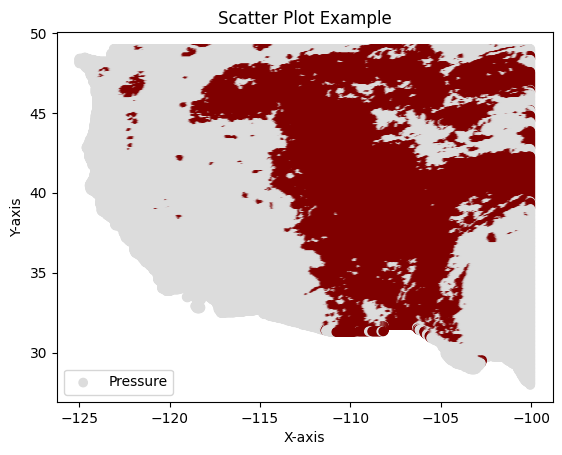

In [80]:
gridmet_folder_name = "../data/gridmet_test_run/gridmet_climatology"
western_us_coords = "../data/dem_file.tif.csv"

# Run the download function
download_gridmet_of_specific_variables(prepare_folder_and_get_year_list())
turn_gridmet_nc_to_csv()
plot_gridmet()

# prepare testing data with cumulative variables
prepare_cumulative_history_csvs(force=True)

## Utility Functions for Merging Meteorological Data for Comprehensive Analysis

## 1. Importing Libraries

The code snippet sets up the environment and defines the necessary paths and timeframes for a data processing task



In [7]:
def merge_similar_variables_from_different_years():
    files = os.listdir(gridmet_save_location)
    file_groups = {}

    for filename in files:
        base_name, year_ext = os.path.splitext(filename)
        parts = base_name.split('_')
        if len(parts) == 2 and year_ext == '.csv':
            file_groups.setdefault(parts[0], []).append(filename)

    for base_name, file_list in file_groups.items():
        if len(file_list) > 1:
            dfs = []
            for filename in file_list[:5]:
                df = pd.read_csv(os.path.join(gridmet_save_location, filename))
                dfs.append(df)
            merged_df = pd.concat(dfs, ignore_index=True)
            merged_filename = f"{base_name}_merged.csv"
            merged_df.to_csv(os.path.join(gridmet_save_location, merged_filename), index=False)
            print(f"Merged {file_list} into {merged_filename}")

## 2. Get Files from a Directory
We collect the names of files with the extension ".nc" within a specified directory by iterating through all files, appending their names to a list, and returning the list.

In [13]:
def get_files_in_directory():
    f = list()
    for files in glob.glob(gridmet_save_location + "/*.nc"):
        f.append(files)
    return f

## 3. Download File from a URL

Here we download a file from a given URL and saves it to a specified location on your system.

In [14]:
def download_file(url, save_location):
    try:
        print("download_file")
        with urllib.request.urlopen(url) as response:
            file_content = response.read()
        file_name = os.path.basename(url)
        save_path = os.path.join(save_location, file_name)
        with open(save_path, 'wb') as file:
            file.write(file_content)
        print(f"File downloaded successfully and saved as: {save_path}")
    except Exception as e:
        print(f"An error occurred while downloading the file: {str(e)}")

## 4. Download GridMET Climatology Data

We attempt to download a file from a specified URL. We then save the downloaded file to a specified location.

- `folder_name = `: Sets the directory where the files will be saved.

- For each variable in `variables_list`, we loop through the `year_list`.
- And the download link for each file is constructed by combining the base URL, variable name, and year.
- If the file does not already exist in the specified folder, it is downloaded using the `download_file()` function.

In [15]:
def download_gridmet_climatology():
    folder_name = gridmet_save_location
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    base_metadata_url = "http://www.northwestknowledge.net/metdata/data/"
    variables_list = ['tmmn', 'tmmx', 'pr', 'vpd', 'etr', 'rmax', 'rmin', 'vs']

    for var in variables_list:
        for y in year_list:
            download_link = base_metadata_url + var + '_' + '%s' % y + '.nc'
            print("downloading", download_link)
            if not os.path.exists(os.path.join(folder_name, var + '_' + '%s' % y + '.nc')):
                download_file(download_link, folder_name)

## 3.2.2 Merging Meteorological Data for Comprehensive Analysis

In this chapter, we do
- `Data Collection:`  We fetch gridMET climatology data for various meteorological variables (e.g., temperature, precipitation) and multiple years. 

- `Data Processing:` After downloading, we extract relevant data for specific geographical locations corresponding to weather stations.

- `Data Integration:` We merge similar variables obtained from different years into separate CSV files. We then combine all variables together into a single comprehensive dataset for further analysis and modeling tasks.

## 3.2.2.1 Extracting and Saving Data from a NetCDF File

Here we read data from a NetCDF file, extracts specific variables, and saves the data as a CSV file.

- `ds = xr.open_dataset(file_name)`: Opens the NetCDF file for reading.
- `var_to_extract = list(ds.keys())`: Extracts the variable names present in the dataset.
- `var_name = var_to_extract[0]`: Selects the first variable from the list for further processing.

For each station (defined in `stations`), we extract the latitude (`lat`) and longitude (`lon`).
Using `ds.sel(lat=lat, lon=lon, method='nearest')`, we select the data nearest to the specified latitude and longitude and then convert the subset data into a DataFrame.

In [6]:
def get_gridmet_variable(file_name):
    print(f"reading values from {file_name}")
    result_data = []
    ds = xr.open_dataset(file_name)
    var_to_extract = list(ds.keys())
    print(var_to_extract)
    var_name = var_to_extract[0]
    
    df = pd.DataFrame(columns=['day', 'lat', 'lon', var_name])
    
    csv_file = f'{gridmet_save_location}/{Path(file_name).stem}.csv'
    if os.path.exists(csv_file):
    	print(f"The file '{csv_file}' exists.")
    	return

    for idx, row in stations.iterrows():
        lat = row['latitude']
        lon = row['longitude']
		
        subset_data = ds.sel(lat=lat, lon=lon, method='nearest')
        subset_data['lat'] = lat
        subset_data['lon'] = lon
        converted_df = subset_data.to_dataframe()
        converted_df = converted_df.reset_index(drop=False)
        converted_df = converted_df.drop('crs', axis=1)
        df = pd.concat([df, converted_df], ignore_index=True)
        
    result_df = df
    print("got result_df : ", result_df.head())
    result_df.to_csv(csv_file, index=False)
    print(f'completed extracting data for {file_name}')

## 3.2.2.2 Merge Similar Variables from Different Years

Here we merge CSV files containing similar variables but from different years. The merged data is saved as a single CSV file for each variable.

- `file_groups = {}`: Initializes an empty dictionary to store grouped files.
- For each file, we extract the base name (variable name) and year, then groups files by the variable name if they end with `.csv`.
- And then Files are grouped based on the part of the filename before the year, ensuring that all files related to the same variable are grouped together.

- Here we start by listing all the files in the specified `gridmet_save_location` directory.
- And then we group the files by their base names (e.g., `temperature`, `precipitation`) by splitting the filename at the underscore (`_`) and checking if the file is a CSV file with a valid year.
- For each group of files (i.e., files with the same variable but from different years), the function reads the first 5 files into pandas DataFrames and merges them into a single DataFrame.
- The merged DataFrame is saved as a new CSV file with the base name followed by `_merged.csv`.

In [12]:
import os
import glob
import urllib.request
from datetime import date, datetime

import pandas as pd
import xarray as xr
from pathlib import Path
import warnings

# Changing the timeframe from 10 years to 6 month to demonstrate
train_start_date = "2021-06-01"
train_end_date = "2021-12-31"

work_dir = "../data/gridmet_test_run"

warnings.filterwarnings("ignore", category=FutureWarning)

start_date = datetime.strptime(train_start_date, "%Y-%m-%d")
end_date = datetime.strptime(train_end_date, "%Y-%m-%d")

year_list = [start_date.year + i for i in range(end_date.year - start_date.year + 1)]

working_dir = work_dir
#stations = pd.read_csv(f'{working_dir}/station_cell_mapping.csv')
all_training_points_with_snotel_ghcnd_file = f"{work_dir}/all_training_points_snotel_ghcnd_in_westus.csv"
stations = pd.read_csv(all_training_points_with_snotel_ghcnd_file)
gridmet_save_location = f'{working_dir}/gridmet_climatology'
final_merged_csv = f"{work_dir}/training_all_point_gridmet_with_snotel_ghcnd.csv"


## 3.2.2.3 Merge All Variables Together

Paths for specific variables (`rmin`, `rmax`, `tmmn`, `tmmx`) are explicitly defined, and their respective CSV files are loaded into DataFrames.

The columns in the specific DataFrames are renamed to distinguish between similar variable names (e.g., `relative_humidity` for `rmin` and `rmax`).

In [8]:
def merge_all_variables_together():
    merged_df = None
    file_paths = []

    for filename in os.listdir(gridmet_save_location)[1:3]:
        if filename.endswith("_merged.csv"):
            file_paths.append(os.path.join(gridmet_save_location, filename))
	
    rmin_merged_path = os.path.join(gridmet_save_location, 'rmin_merged.csv')
    rmax_merged_path = os.path.join(gridmet_save_location, 'rmax_merged.csv')
    tmmn_merged_path = os.path.join(gridmet_save_location, 'tmmn_merged.csv')
    tmmx_merged_path = os.path.join(gridmet_save_location, 'tmmx_merged.csv')
    
    df_rmin = pd.read_csv(rmin_merged_path)
    df_rmax = pd.read_csv(rmax_merged_path , engine='python')
    df_tmmn = pd.read_csv(tmmn_merged_path)
    df_tmmx = pd.read_csv(tmmx_merged_path)
    
    df_rmin.rename(columns={'relative_humidity': 'relative_humidity_rmin'}, inplace=True)
    df_rmax.rename(columns={'relative_humidity': 'relative_humidity_rmax'}, inplace=True)
    df_tmmn.rename(columns={'air_temperature': 'air_temperature_tmmn'}, inplace=True)
    df_tmmx.rename(columns={'air_temperature': 'air_temperature_tmmx'}, inplace=True)
    
    df_rmin.to_csv(os.path.join(gridmet_save_location, 'rmin_merged.csv'))
    df_rmax.to_csv(os.path.join(gridmet_save_location, 'rmax_merged.csv'))
    df_tmmn.to_csv(os.path.join(gridmet_save_location, 'tmmn_merged.csv'))
    df_tmmx.to_csv(os.path.join(gridmet_save_location, 'tmmx_merged.csv'))
    
    if file_paths:
        merged_df = pd.read_csv(file_paths[0])
        for file_path in file_paths[1:3]:
            df = pd.read_csv(file_path)
            merged_df = pd.concat([merged_df, df], axis=1)
        merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
        merged_df.to_csv(final_merged_csv, index=False)


## 3.2.2.4 Workflow for Processing GridMET Climatology Data

- The `download_gridmet_climatology()` function is called to download the necessary climatology data files for various variables.
- `nc_files = get_files_in_directory()`: This retrieves a list of all NetCDF files downloaded in the previous step.
- A loop iterates over the first five NetCDF files in the list (`nc_files`), printing each file's name and extracting data using the `get_gridmet_variable(nc)` function.
- `merge_similar_variables_from_different_years()`: This function is called to merge data files containing the same variable but from different years into a single file for each variable.
- `merge_all_variables_together()`: Finally, this function combines the merged data files for different variables into one comprehensive dataset, allowing for integrated analysis.

In [9]:
download_gridmet_climatology()

nc_files = get_files_in_directory()
for nc in nc_files[:5]:
    get_gridmet_variable(nc)
merge_similar_variables_from_different_years()
merge_all_variables_together()

downloading http://www.northwestknowledge.net/metdata/data/tmmn_2021.nc
downloading http://www.northwestknowledge.net/metdata/data/tmmx_2021.nc
downloading http://www.northwestknowledge.net/metdata/data/pr_2021.nc
downloading http://www.northwestknowledge.net/metdata/data/vpd_2021.nc
downloading http://www.northwestknowledge.net/metdata/data/etr_2021.nc
downloading http://www.northwestknowledge.net/metdata/data/rmax_2021.nc
downloading http://www.northwestknowledge.net/metdata/data/rmin_2021.nc
downloading http://www.northwestknowledge.net/metdata/data/vs_2021.nc
reading values from ../data/gridmet_test_run/gridmet_climatology/rmin_2021.nc
['relative_humidity']
The file '../data/gridmet_test_run/gridmet_climatology/rmin_2021.csv' exists.
reading values from ../data/gridmet_test_run/gridmet_climatology/tmmn_2021.nc
['air_temperature']
The file '../data/gridmet_test_run/gridmet_climatology/tmmn_2021.csv' exists.
reading values from ../data/gridmet_test_run/gridmet_climatology/etr_2021.nc

/opt/homebrew/lib/python3.10/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


['relative_humidity']
The file '../data/gridmet_test_run/gridmet_climatology/rmin_2020.csv' exists.
Merged ['tmmn_2020.csv', 'tmmn_2021.csv', 'tmmn_merged.csv'] into tmmn_merged.csv
Merged ['vs_merged.csv', 'vs_2020.csv', 'vs_2021.csv'] into vs_merged.csv
Merged ['rmax_merged.csv', 'rmax_2020.csv', 'rmax_2021.csv'] into rmax_merged.csv
Merged ['etr_merged.csv', 'etr_2020.csv', 'etr_2021.csv'] into etr_merged.csv
Merged ['vpd_merged.csv', 'vpd_2020.csv', 'vpd_2021.csv'] into vpd_merged.csv
Merged ['tmmx_2021.csv', 'tmmx_2020.csv', 'tmmx_merged.csv'] into tmmx_merged.csv
Merged ['pr_2021.csv', 'pr_2020.csv', 'pr_merged.csv'] into pr_merged.csv
Merged ['rmin_2021.csv', 'rmin_merged.csv', 'rmin_2020.csv'] into rmin_merged.csv
